<a href="https://colab.research.google.com/github/camillabocciolone/Leonardo-project/blob/main/baselinebandpower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [1]:
!pip -q install einops tqdm scikit-learn scipy

import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



## --- Repo EEGPT ---

In [2]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Usa il checkpoint direttamente da Drive

In [5]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: True


## Clona il repo

In [6]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [7]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


# EEGPT on the true dataset

## ridefiniamo build all usando rec_id

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [8]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8, time_col=22):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    df = df.iloc[1:, :].reset_index(drop=True)

    # EEG: prime C colonne → (T,C)
    X = df.iloc[:, :C].to_numpy(dtype=np.float32)

    # TIME (se ti serve)
    t = pd.to_numeric(df.iloc[:, time_col], errors="coerce").to_numpy(np.float64)

    return X, t   # X:(T,C)


def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    # X: (T,C), t: (T,) in secondi (o ms), monotono

    # filtri: non cambiano la lunghezza
    x = bandpass(X, fs_in)
    x = notch50(x, fs_in)
    x = detrend(x, axis=0, type='linear')
    x = robust_clip(x, q=0.999)

    # resampling: cambia lunghezza → devi resamplare anche t
    x = resample_to(x, fs_in, FS_OUT)

    if t is None:
        t_rs = np.arange(x.shape[0]) / FS_OUT
    else:
        t = np.asarray(t, dtype=np.float64)
        # ricreo una griglia uniforme tra inizio e fine, lunga come x dopo resample
        t_rs = np.linspace(t[0], t[-1], num=x.shape[0])

    # epoche: taglio anche t
    epochs = epoch_signal(x, FS_OUT)  # (N, win, C)
    if epochs.shape[0] == 0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32), None

    epochs = np.transpose(epochs, (0,2,1))  # (N,C,win)

    # costruisco anche t per ogni epoca
    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, x.shape[0] - win + 1, step)
    t_epochs = np.stack([t_rs[s:s+win] for s in starts], axis=0)  # (N, win)

    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[0], epochs[0, ch_idx, :])
        plt.xlabel("Time")
        plt.title(f"Epoch[0] (ch {ch_idx})")
        plt.tight_layout()
        plt.show()

    # robust z-score
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)

    return epochs.astype(np.float32), t_epochs





    return epochs.astype(np.float32)

In [13]:
def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    """
    X: (T,C)
    t: (T,) opzionale, NON equidistante
    Ritorna:
      epochs: (N,C,win)
      t_epochs: (N,win) in secondi, equispaziati
    """

    # --- sanity ---
    X = np.asarray(X, dtype=np.float32)
    if X.ndim != 2:
        raise ValueError("X deve essere (T,C)")

    # --- filtri (come prima, ma multi) ---
    x = bandpass(X, fs_in)
    x = notch50(x, fs_in)
    x = detrend(x, axis=0, type="linear")
    x = robust_clip(x, q=0.999)

    # --- resample ---
    x = resample_to(x, fs_in, FS_OUT)   # (T2,C)
    T2, C = x.shape

    # --- tempo COME NEL VECCHIO ---
    # campioni equispaziati, fs fisso
    if t is None:
        t0 = 0.0
    else:
        t = np.asarray(t)
        m = np.isfinite(t)
        t0 = float(t[m][0]) if np.any(m) else 0.0

    t_rs = t0 + np.arange(T2) / FS_OUT   # (T2,)

    # --- epoching A INDICI (IDENTICO AL SINGLE) ---
    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, T2 - win + 1, step)

    if len(starts) == 0:
        return np.empty((0, C, win)), np.empty((0, win))

    epochs = np.stack([x[s:s+win] for s in starts], axis=0)      # (N,win,C)
    epochs = np.transpose(epochs, (0,2,1))                      # (N,C,win)
    t_epochs = np.stack([t_rs[s:s+win] for s in starts], axis=0)

    # --- DEBUG PLOT (DECENTE) ---
    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(
            t_epochs[0] - t_epochs[0,0],
            epochs[0, ch_idx],
            linewidth=0.8
        )
        plt.xlabel("Time (s)")
        plt.title(f"Epoch 0 – channel {ch_idx}")
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()

    # --- z-score robusto (come prima) ---
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)

    return epochs.astype(np.float32), t_epochs



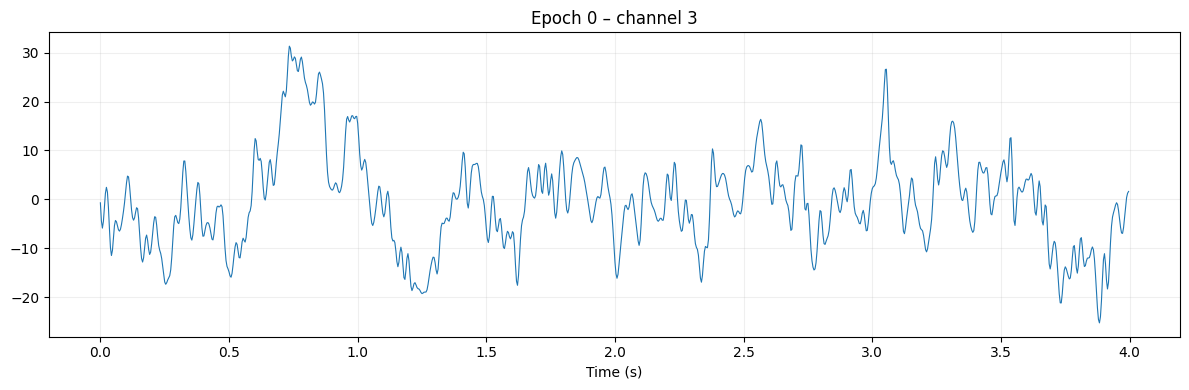

(43, 8, 1024)


In [14]:
task = "Stroop"
level = "highlevel"
subject = 3

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording(
    X, t,
    debug=True,
    ch_idx=3
)

print(epochs.shape)  # (N, C, win)




## build_all

In [15]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:

                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)

                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([li]*len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


## baseline bandpower

In [16]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [17]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [18]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.230 | f1m=0.205
fold 02 | test_subject=S10 | n_win=158 | acc=0.506 | f1m=0.385
fold 03 | test_subject=S11 | n_win=179 | acc=0.408 | f1m=0.352


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=166 | acc=0.416 | f1m=0.383
fold 05 | test_subject=S13 | n_win=154 | acc=0.422 | f1m=0.349


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 06 | test_subject=S14 | n_win=137 | acc=0.533 | f1m=0.369
fold 07 | test_subject=S15 | n_win=156 | acc=0.590 | f1m=0.483
fold 08 | test_subject=S2 | n_win=225 | acc=0.449 | f1m=0.185


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=153 | acc=0.458 | f1m=0.374
fold 10 | test_subject=S4 | n_win=126 | acc=0.310 | f1m=0.248
fold 11 | test_subject=S5 | n_win=175 | acc=0.446 | f1m=0.343


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 12 | test_subject=S6 | n_win=145 | acc=0.338 | f1m=0.298
fold 13 | test_subject=S7 | n_win=146 | acc=0.452 | f1m=0.384
fold 14 | test_subject=S8 | n_win=197 | acc=0.376 | f1m=0.249


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 15 | test_subject=S9 | n_win=229 | acc=0.533 | f1m=0.371

=== GLOBAL ===
acc: 0.43293650793650795
balanced_acc: 0.372880261686252
f1_macro: 0.358338410591301
f1_weighted: 0.40888086885132063
Confusion matrix:
 [[386  88 114 156]
 [199  37  97 126]
 [167  80 105 130]
 [157  28  87 563]]

Report:
               precision    recall  f1-score   support

           0      0.425     0.519     0.467       744
           1      0.159     0.081     0.107       459
           2      0.261     0.218     0.237       482
           3      0.577     0.674     0.622       835

    accuracy                          0.433      2520
   macro avg      0.355     0.373     0.358      2520
weighted avg      0.395     0.433     0.409      2520



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.229885,0.233299,0.204707,0.204256
1,S10,158,0.506329,0.413659,0.385066,0.459074
2,S11,179,0.407821,0.361043,0.351512,0.405305
3,S12,166,0.415663,0.399437,0.383414,0.417862
4,S13,154,0.422078,0.398068,0.349398,0.365387
5,S14,137,0.532847,0.423454,0.368582,0.455028
6,S15,156,0.589744,0.544664,0.482628,0.513614
7,S2,225,0.448889,0.234448,0.185285,0.345842
8,S3,153,0.457516,0.399135,0.374303,0.425460
9,S4,126,0.309524,0.276895,0.247853,0.307352



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.190 | f1m=0.170
fold 02 | test_subject=S10 | n_win=158 | acc=0.494 | f1m=0.381


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=179 | acc=0.391 | f1m=0.315
fold 04 | test_subject=S12 | n_win=166 | acc=0.386 | f1m=0.348


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.338 | f1m=0.251
fold 06 | test_subject=S14 | n_win=137 | acc=0.518 | f1m=0.346


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=156 | acc=0.635 | f1m=0.571
fold 08 | test_subject=S2 | n_win=225 | acc=0.436 | f1m=0.198


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=153 | acc=0.451 | f1m=0.352
fold 10 | test_subject=S4 | n_win=126 | acc=0.429 | f1m=0.381


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=175 | acc=0.429 | f1m=0.351
fold 12 | test_subject=S6 | n_win=145 | acc=0.462 | f1m=0.440


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=146 | acc=0.452 | f1m=0.411
fold 14 | test_subject=S8 | n_win=197 | acc=0.386 | f1m=0.262
fold 15 | test_subject=S9 | n_win=229 | acc=0.528 | f1m=0.338

=== GLOBAL ===
acc: 0.43373015873015874
balanced_acc: 0.3799184634052796
f1_macro: 0.37092694435658
f1_weighted: 0.4135379910197552
Confusion matrix:
 [[387  49 123 185]
 [190  64 100 105]
 [185  48 104 145]
 [164  28 105 538]]

Report:
               precision    recall  f1-score   support

           0      0.418     0.520     0.463       744
           1      0.339     0.139     0.198       459
           2      0.241     0.216     0.228       482
           3      0.553     0.644     0.595       835

    accuracy                          0.434      2520
   macro avg      0.388     0.380     0.371      2520
weighted avg      0.414     0.434     0.414      2520



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.189655,0.187926,0.169864,0.174345
1,S10,158,0.493671,0.407110,0.381218,0.452136
2,S11,179,0.391061,0.331847,0.315437,0.381881
3,S12,166,0.385542,0.361864,0.348457,0.382992
4,S13,154,0.337662,0.301723,0.251326,0.266961
5,S14,137,0.518248,0.407741,0.345956,0.434532
6,S15,156,0.634615,0.596174,0.571491,0.599450
7,S2,225,0.435556,0.231675,0.198077,0.349648
8,S3,153,0.450980,0.391418,0.351911,0.399007
9,S4,126,0.428571,0.422265,0.380589,0.420439


# cambiamenti
- 128 patch size vuol dire che dati 4 s si hanno 1024/128 = 8 campioni invece degli attuali 64 patch size che sarebbe 1024/64=16 campioni
- in task dividere aithmetic e stroops
- Il robust z-score per epoca (MAD) può “ammazzare” la separabilità tra classi --> eliminarlo
- aggiungere interpolazione per avere istanti temporali equidistanti
- cambiare parametri tsn
- Patch stride: prova 128 e 256
- Bonus: 2 baseline che ti dicono subito se il dataset ha segnale
A) Bandpower baseline (fortissima per workload)
Estrai per finestra:
log bandpower in delta/theta/alpha/beta (per canale)
poi LDA / logistic
Se questa baseline non supera tipo ~45–55% (3 classi), il dataset potrebbe avere segnale debole o label rumorose.
B) Relative power
Stessa cosa, ma dividi ogni banda per il totale (stabilizza soggetti).
- cambiare dataset


# EEGPT on true datset using interpolation

In [19]:
import pandas as pd, numpy as np

path = find_file("highlevel", "Stroop", 3)  # cambia soggetto/level se vuoi
df = pd.read_csv(path, sep=",", header=None, engine="python")

t = pd.to_numeric(df.iloc[:, 22], errors="coerce").to_numpy()
t = t[~np.isnan(t)]
t = t - t[0]
dt = np.diff(t)

print("dt mean:", dt.mean())
print("dt std :", dt.std())
print("dt min :", dt.min(), "dt max:", dt.max())
print("fs approx:", 1/dt.mean())
print("dropouts (dt > 2*mean):", np.sum(dt > 2*dt.mean()))


dt mean: 0.005021807866576204
dt std : 0.03322592742888936
dt min : 7.3909759521484375e-06 dt max: 0.48257970809936523
fs approx: 199.13147347904922
dropouts (dt > 2*mean): 1410


In [20]:
# ====== SETUP ======
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

# ====== PARAMETRI (come i tuoi) ======
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels   = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks    = ["Stroop"]                               # cambia se vuoi anche Arithmetic ecc
subjects = range(1, 16)

C = 8
TIME_COL = 22

# dal tuo log: fs approx ~199 => usiamo griglia uniforme a 200Hz, poi portiamo a 256
FS_U   = 200.0
FS_OUT = 256.0

EPOCH_SEC  = 4.0
STRIDE_SEC = 2.0

BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0


# ====== UTILS: trova file in entrambi i layout ======
def find_file(level, task, subject):
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None


# ====== LOAD: (C,T) + time ======
def load_ct_with_time(path, C=8, time_col=22):
    df = pd.read_csv(path, sep=",", header=None, engine="python")

    # come vecchio: elimina prima riga "brutta"
    df = df.iloc[1:, :].reset_index(drop=True)

    X = df.iloc[:, :C].to_numpy(dtype=np.float32).T  # (C, T_raw)
    t = pd.to_numeric(df.iloc[:, time_col], errors="coerce").to_numpy(np.float64)

    # qui puoi tenere il mask sui NaN tempo (ok)
    mask = np.isfinite(t)
    X = X[:, mask]
    t = t[mask]

    # porta a partire da 0 usando primo campione valido
    t = t - t[0]

    # strictly increasing
    keep = np.r_[True, np.diff(t) > 0]
    X = X[:, keep]
    t = t[keep]

    # unique
    t_unique, idx = np.unique(t, return_index=True)
    return X[:, idx], t_unique

def make_uniform_time(t0, n, fs):
    return t0 + np.arange(n, dtype=np.float64) / fs



# ====== Interpolazione su griglia uniforme ======
def to_uniform_grid(X_ct, t, fs_u=200.0):
    t_end = t[-1]
    t_u = np.arange(0.0, t_end, 1.0/fs_u)

    f = interp1d(
        t, X_ct, axis=1, kind="linear",
        bounds_error=False,
        fill_value=(X_ct[:, 0], X_ct[:, -1])
    )
    X_u = f(t_u).astype(np.float32)  # (C, T_u)
    return X_u, t_u



# ====== Filtri + clip ======
def bandpass_tc(x_tc, fs, lo=0.5, hi=45.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x_tc, axis=0)

def notch_tc(x_tc, fs, f0=50.0, Q=30.0):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x_tc, axis=0)

def robust_clip_tc(x_tc, q=0.999):
    hi = np.quantile(x_tc, q, axis=0, keepdims=True)
    lo = np.quantile(x_tc, 1-q, axis=0, keepdims=True)
    return np.clip(x_tc, lo, hi)


# ====== Epoching (x_tc: (T,C) -> (N,C,1024)) ======
def epoch_signal_tc(x_tc, fs, epoch_sec=4.0, stride_sec=2.0):
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts) == 0:
        return np.empty((0, x_tc.shape[1], win), dtype=np.float32), starts
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0).astype(np.float32)  # (N,win,C)
    epochs = np.transpose(epochs, (0, 2, 1))  # (N,C,win)
    return epochs, starts



# ====== Preprocess completo di una registrazione irregolare ======
def preprocess_recording_irregular(path, C=8, debug=False, ch_idx=0):
    # 1) load (C,T) e time (irregolare)
    X_ct, t = load_ct_with_time(path, C=C, time_col=TIME_COL)
    t0 = float(t[0])  # dopo il -t[0], t0 sarà 0 di solito, ma lo teniamo

    # 2) interpolazione a griglia uniforme FS_U
    X_u, t_u = to_uniform_grid(X_ct, t, fs_u=FS_U)   # (C,Tu), t_u uniforme a FS_U

    # 3) filtri su FS_U
    x = X_u.T  # (Tu,C)
    x = bandpass_tc(x, FS_U, lo=BP_LO, hi=BP_HI)
    x = notch_tc(x, FS_U, f0=NOTCH_F0, Q=NOTCH_Q)
    x = detrend(x, axis=0, type="linear")
    x = robust_clip_tc(x, q=0.999)

    # 4) resample FS_U -> FS_OUT
    x = resample_poly(x, up=32, down=25, axis=0).astype(np.float32)  # (T256,C)

    # tempo coerente DOPO resample: non linspace, ma campioni/fs
    t_rs = make_uniform_time(t0, x.shape[0], FS_OUT)  # (T256,)

    # 5) epoching + tempo epoche
    epochs, starts = epoch_signal_tc(x, FS_OUT, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC)
    if epochs.shape[0] == 0:
        return (np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32),
                np.empty((0, int(EPOCH_SEC*FS_OUT)), dtype=np.float64))

    win = int(EPOCH_SEC * FS_OUT)
    t_epochs = np.stack([t_rs[s:s+win] for s in starts], axis=0)  # (N,win)

    # 6) robust z-score per epoca/canale (se lo vuoi davvero)
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    # epochs = (epochs - med) / (1.4826 * mad)

    if debug:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[0] - t_epochs[0,0], epochs[0, ch_idx], linewidth=0.8)
        plt.xlabel("Time (s) within epoch")
        plt.title(f"Epoch 0 – ch {ch_idx}")
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()

    return epochs.astype(np.float32), t_epochs



# ====== BUILD ALL: X_all, y_all, meta ======
def build_all(levels, tasks, subjects, C=8, verbose=True):
    X_list = []
    y_list = []
    subj_list = []
    task_list = []
    level_list = []
    recid_list = []   # id per TSN: 1 registrazione = 1 rec_id

    rec_id = 0
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    if verbose: print(f"[SKIP] missing file: level={level} task={task} subj={s}")
                    continue
                try:
                    epochs, _ = preprocess_recording_irregular(path, C=C, debug=False)

                    if epochs.shape[0] == 0:
                        if verbose: print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    X_list.append(epochs)
                    y_list.extend([li] * len(epochs))
                    subj_list.extend([f"S{s}"] * len(epochs))
                    task_list.extend([task] * len(epochs))
                    level_list.extend([level] * len(epochs))
                    recid_list.extend([rec_id] * len(epochs))

                    rec_id += 1
                except Exception as e:
                    if verbose: print(f"[ERR] {os.path.basename(path)}: {e}")
                    continue

    if len(X_list) == 0:
        return (np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32),
                np.empty((0,), dtype=np.int64),
                {"subject": np.array([]), "task": np.array([]), "level": np.array([]), "rec_id": np.array([])})

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)  # (N,C,1024)
    y_all = np.array(y_list, dtype=np.int64)

    meta = {
        "subject": np.array(subj_list),
        "task":    np.array(task_list),
        "level":   np.array(level_list),
        "rec_id":  np.array(recid_list, dtype=np.int64),
    }
    return X_all, y_all, meta

# ====== ESECUZIONE ======
X_win, y_win, meta = build_all(levels, tasks, subjects, C=C, verbose=True)
print("X_all:", X_win.shape, "y_all:", y_win.shape)
print("unique y:", np.unique(y_win, return_counts=True))


# 2) recording-level table
rec_id_win = meta["rec_id"]
subj_win   = meta["subject"]
y_win_lbl  = y_win

rec_ids = np.unique(rec_id_win)

rec_subjects = []
rec_y = []
for rid in rec_ids:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_subjects.append(subj_win[idx0])
    rec_y.append(int(y_win_lbl[idx0]))

rec_subjects = np.array(rec_subjects)
rec_y = np.array(rec_y, dtype=np.int64)

# 3) split subject-independent sui RECORDING
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({
        "train_rec": set(rec_ids[tr_idx]),
        "val_rec":   set(rec_ids[va_idx]),
        "test_rec":  set(rec_ids[test_idx])
    })

FOLD = 0
train_rec = folds[FOLD]["train_rec"]
val_rec   = folds[FOLD]["val_rec"]
test_rec  = folds[FOLD]["test_rec"]

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))



# ====== recording-level table ======
rec_id_win = meta["rec_id"]
subj_win   = meta["subject"]
y_win_lbl  = y_win  # (n_windows,)

rec_ids = np.unique(rec_id_win)

rec_subjects = []
rec_y = []
for rid in rec_ids:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_subjects.append(subj_win[idx0])
    rec_y.append(int(y_win_lbl[idx0]))

rec_subjects = np.array(rec_subjects)
rec_y = np.array(rec_y, dtype=np.int64)

# ====== 5-fold subject-independent sui RECORDING ======
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({
        "train_rec": set(rec_ids[tr_idx]),
        "val_rec":   set(rec_ids[va_idx]),
        "test_rec":  set(rec_ids[test_idx])
    })

FOLD = 0
train_rec = folds[FOLD]["train_rec"]
val_rec   = folds[FOLD]["val_rec"]
test_rec  = folds[FOLD]["test_rec"]

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))







Mounted at /content/drive
X_all: (2584, 8, 1024) y_all: (2584,)
unique y: (array([0, 1, 2, 3]), array([761, 472, 487, 864]))
Fold0 recordings: 36 12 12
Fold0 recordings: 36 12 12


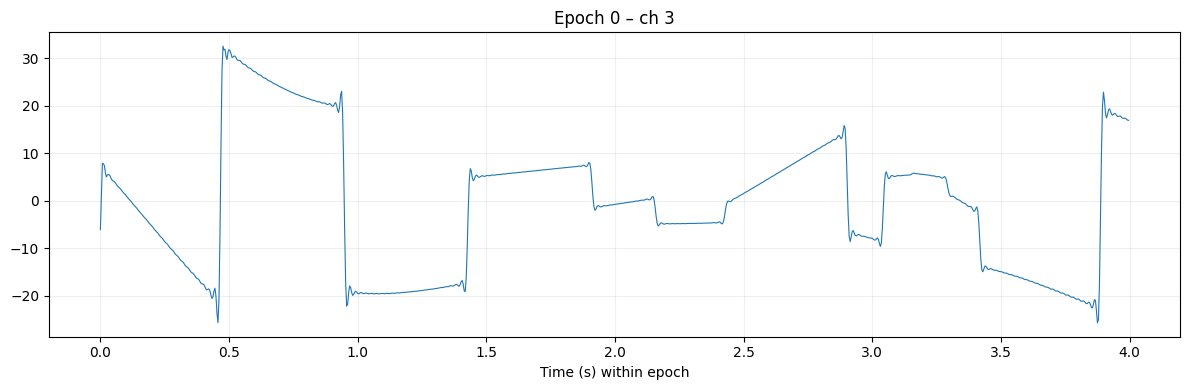

(54, 8, 1024)


In [22]:
task = "Stroop"
level = "highlevel"
subject = 3

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording_irregular(path, C=8, debug=True, ch_idx=3)


print(epochs.shape)

## baseline bandpower

In [23]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [24]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [25]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.400 | f1m=0.338
fold 02 | test_subject=S10 | n_win=158 | acc=0.335 | f1m=0.203
fold 03 | test_subject=S11 | n_win=183 | acc=0.306 | f1m=0.256


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=167 | acc=0.275 | f1m=0.243


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=153 | acc=0.451 | f1m=0.282
fold 06 | test_subject=S14 | n_win=139 | acc=0.417 | f1m=0.255


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.459 | f1m=0.387


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=224 | acc=0.527 | f1m=0.364


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=179 | acc=0.475 | f1m=0.393


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=132 | acc=0.379 | f1m=0.143
fold 11 | test_subject=S5 | n_win=174 | acc=0.236 | f1m=0.161


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 12 | test_subject=S6 | n_win=152 | acc=0.316 | f1m=0.210


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=149 | acc=0.181 | f1m=0.092
fold 14 | test_subject=S8 | n_win=196 | acc=0.291 | f1m=0.204


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 15 | test_subject=S9 | n_win=231 | acc=0.199 | f1m=0.194

=== GLOBAL ===
acc: 0.34907120743034054
balanced_acc: 0.2974567155903204
f1_macro: 0.2825958694195295
f1_weighted: 0.317822934084229
Confusion matrix:
 [[353  45  14 349]
 [148  42  53 229]
 [180  40  56 211]
 [300  60  53 451]]

Report:
               precision    recall  f1-score   support

           0      0.360     0.464     0.405       761
           1      0.225     0.089     0.127       472
           2      0.318     0.115     0.169       487
           3      0.364     0.522     0.429       864

    accuracy                          0.349      2584
   macro avg      0.317     0.297     0.283      2584
weighted avg      0.329     0.349     0.318      2584



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.400000,0.365510,0.337885,0.365581
1,S10,158,0.335443,0.260795,0.203305,0.264622
2,S11,183,0.306011,0.260585,0.256129,0.272344
3,S12,167,0.275449,0.250966,0.242579,0.260281
4,S13,153,0.450980,0.362921,0.281955,0.350091
5,S14,139,0.417266,0.332641,0.255318,0.322051
6,S15,157,0.458599,0.477643,0.386597,0.393272
7,S2,224,0.526786,0.363806,0.363522,0.483577
8,S3,179,0.474860,0.417152,0.393242,0.434214
9,S4,132,0.378788,0.245098,0.142857,0.220779



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.400 | f1m=0.290
fold 02 | test_subject=S10 | n_win=158 | acc=0.342 | f1m=0.214


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=183 | acc=0.295 | f1m=0.198
fold 04 | test_subject=S12 | n_win=167 | acc=0.305 | f1m=0.229


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=153 | acc=0.431 | f1m=0.285
fold 06 | test_subject=S14 | n_win=139 | acc=0.331 | f1m=0.203


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.268 | f1m=0.203
fold 08 | test_subject=S2 | n_win=224 | acc=0.487 | f1m=0.270


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=179 | acc=0.441 | f1m=0.340
fold 10 | test_subject=S4 | n_win=132 | acc=0.280 | f1m=0.196


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=174 | acc=0.310 | f1m=0.212
fold 12 | test_subject=S6 | n_win=152 | acc=0.546 | f1m=0.509


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=149 | acc=0.168 | f1m=0.116
fold 14 | test_subject=S8 | n_win=196 | acc=0.321 | f1m=0.224
fold 15 | test_subject=S9 | n_win=231 | acc=0.394 | f1m=0.253

=== GLOBAL ===
acc: 0.35990712074303405
balanced_acc: 0.29810712561274266
f1_macro: 0.270407765206786
f1_weighted: 0.31382563358967763
Confusion matrix:
 [[365  20  41 335]
 [220  37  23 192]
 [236  10  26 215]
 [294  14  54 502]]

Report:
               precision    recall  f1-score   support

           0      0.327     0.480     0.389       761
           1      0.457     0.078     0.134       472
           2      0.181     0.053     0.082       487
           3      0.404     0.581     0.476       864

    accuracy                          0.360      2584
   macro avg      0.342     0.298     0.270      2584
weighted avg      0.349     0.360     0.314      2584



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.400000,0.346102,0.290138,0.331649
1,S10,158,0.341772,0.267992,0.214204,0.278568
2,S11,183,0.295082,0.235603,0.197915,0.246702
3,S12,167,0.305389,0.268193,0.228609,0.253556
4,S13,153,0.431373,0.355217,0.285384,0.334650
5,S14,139,0.330935,0.266476,0.203125,0.255845
6,S15,157,0.267516,0.238674,0.202929,0.221235
7,S2,224,0.486607,0.320451,0.269962,0.437921
8,S3,179,0.441341,0.377320,0.340305,0.387669
9,S4,132,0.280303,0.215046,0.196154,0.252235


# solo 3 classi on the true dataset

In [26]:
LEVEL_TO_Y = {
    "natural":   0,
    "lowlevel":  1,
    "midlevel":  2,
    "highlevel": 2,
}


In [27]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [28]:

def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8, time_col=22):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    df = df.iloc[1:, :].reset_index(drop=True)

    # EEG: prime C colonne → (T,C)
    X = df.iloc[:, :C].to_numpy(dtype=np.float32)

    # TIME (se ti serve)
    t = pd.to_numeric(df.iloc[:, time_col], errors="coerce").to_numpy(np.float64)

    return X, t   # X:(T,C)


def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    # X: (T,C), t: (T,) in secondi (o ms), monotono

    # filtri: non cambiano la lunghezza
    x = bandpass(X, fs_in)
    x = notch50(x, fs_in)
    x = detrend(x, axis=0, type='linear')
    x = robust_clip(x, q=0.999)

    # resampling: cambia lunghezza → devi resamplare anche t
    x = resample_to(x, fs_in, FS_OUT)

    if t is None:
        t_rs = np.arange(x.shape[0]) / FS_OUT
    else:
        t = np.asarray(t, dtype=np.float64)
        # ricreo una griglia uniforme tra inizio e fine, lunga come x dopo resample
        t_rs = np.linspace(t[0], t[-1], num=x.shape[0])

    # epoche: taglio anche t
    epochs = epoch_signal(x, FS_OUT)  # (N, win, C)
    if epochs.shape[0] == 0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32), None

    epochs = np.transpose(epochs, (0,2,1))  # (N,C,win)

    # costruisco anche t per ogni epoca
    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, x.shape[0] - win + 1, step)
    t_epochs = np.stack([t_rs[s:s+win] for s in starts], axis=0)  # (N, win)

    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[0], epochs[0, ch_idx, :])
        plt.xlabel("Time")
        plt.title(f"Epoch[0] (ch {ch_idx})")
        plt.tight_layout()
        plt.show()

    # robust z-score
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)

    return epochs.astype(np.float32), t_epochs





    return epochs.astype(np.float32)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def debug_preprocessing_plot(X_ct, fs_in=250, fs_out=256, ch_names=None, ch_idx=0, seconds=10):
    x_raw = X_ct.T  # (T,C)
    n = min(x_raw.shape[0], int(seconds*fs_in))

    x_bp = bandpass(x_raw.copy(), fs_in)
    x_notch = notch50(x_bp, fs_in)
    x_det = detrend(x_notch, axis=0, type='linear')
    x_clip = robust_clip(x_det, q=0.999)
    x_rs = resample_to(x_clip, fs_in, fs_out)

    name = ch_names[ch_idx] if ch_names is not None else f"ch{ch_idx}"

    # TIME SERIES
    t = np.arange(n)/fs_in
    plt.figure(figsize=(12,4))
    plt.plot(t, x_raw[:n, ch_idx], label="raw", alpha=0.9)
    plt.plot(t, x_bp[:n, ch_idx], label="bandpass", alpha=0.9)
    plt.plot(t, x_notch[:n, ch_idx], label="bandpass+notch", alpha=0.9)
    plt.title(f"Time series ({name}) first {seconds}s")
    plt.xlabel("s")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PSD raw vs filtered
    f1, p1 = welch(x_raw[:, ch_idx], fs=fs_in, nperseg=min(len(x_raw), 2*fs_in))
    f2, p2 = welch(x_notch[:, ch_idx], fs=fs_in, nperseg=min(len(x_notch), 2*fs_in))

    plt.figure(figsize=(12,4))
    plt.semilogy(f1, p1, label="raw PSD")
    plt.semilogy(f2, p2, label="filtered PSD")
    plt.axvline(50, linestyle="--")
    plt.xlim(0, 60)
    plt.title(f"PSD ({name}) — 50Hz peak should drop after notch")
    plt.xlabel("Hz")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Lengths:")
    print("raw T:", x_raw.shape[0], "fs_in:", fs_in)
    print("resampled T:", x_rs.shape[0], "fs_out:", fs_out)


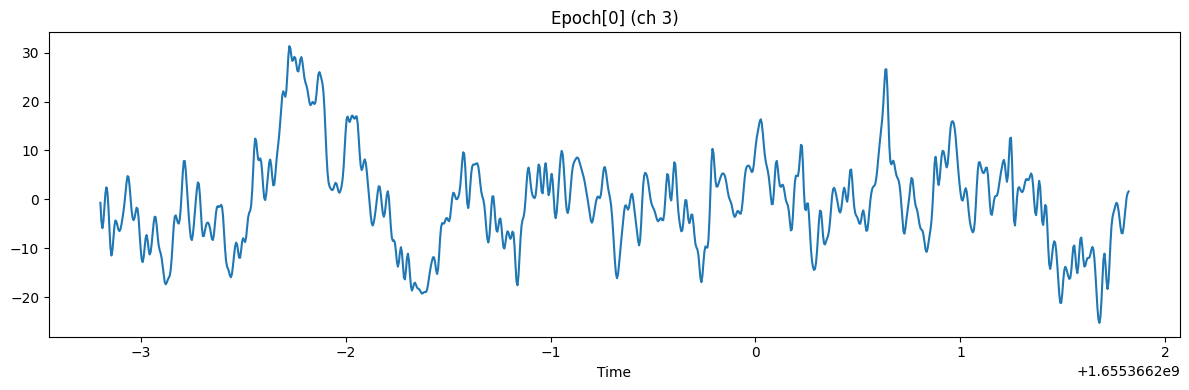

(43, 8, 1024)


In [30]:
task = "Stroop"
level = "highlevel"
subject = 3

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording(
    X, t,
    debug=True,
    ch_idx=3
)

print(epochs.shape)  # (N, C, win)

## build_all

In [31]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


In [32]:
print("unique y:", np.unique(y_all, return_counts=True))


unique y: (array([0, 1, 2]), array([ 835,  482, 1203]))


## baseline bandpower

In [33]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [34]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [35]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.339 | f1m=0.304
fold 02 | test_subject=S10 | n_win=158 | acc=0.589 | f1m=0.456
fold 03 | test_subject=S11 | n_win=179 | acc=0.631 | f1m=0.470


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=166 | acc=0.524 | f1m=0.510
fold 05 | test_subject=S13 | n_win=154 | acc=0.669 | f1m=0.571
fold 06 | test_subject=S14 | n_win=137 | acc=0.766 | f1m=0.570


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=156 | acc=0.705 | f1m=0.561
fold 08 | test_subject=S2 | n_win=225 | acc=0.480 | f1m=0.320
fold 09 | test_subject=S3 | n_win=153 | acc=0.654 | f1m=0.506


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=126 | acc=0.556 | f1m=0.323
fold 11 | test_subject=S5 | n_win=175 | acc=0.577 | f1m=0.445
fold 12 | test_subject=S6 | n_win=145 | acc=0.366 | f1m=0.273


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=146 | acc=0.589 | f1m=0.535
fold 14 | test_subject=S8 | n_win=197 | acc=0.492 | f1m=0.361
fold 15 | test_subject=S9 | n_win=229 | acc=0.664 | f1m=0.493


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== GLOBAL ===
acc: 0.5702380952380952
balanced_acc: 0.48020122253810893
f1_macro: 0.46711993259755974
f1_weighted: 0.5412687151512446
Confusion matrix:
 [[519  59 257]
 [ 97  45 340]
 [233  97 873]]

Report:
               precision    recall  f1-score   support

           0      0.611     0.622     0.616       835
           1      0.224     0.093     0.132       482
           2      0.594     0.726     0.653      1203

    accuracy                          0.570      2520
   macro avg      0.476     0.480     0.467      2520
weighted avg      0.529     0.570     0.541      2520



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.339080,0.300086,0.303860,0.340835
1,S10,158,0.588608,0.497739,0.455857,0.537155
2,S11,179,0.631285,0.494880,0.470155,0.571880
3,S12,166,0.524096,0.493970,0.509936,0.556318
4,S13,154,0.668831,0.591615,0.571173,0.652849
5,S14,137,0.766423,0.605126,0.570276,0.696663
6,S15,156,0.705128,0.591143,0.560575,0.652064
7,S2,225,0.480000,0.342220,0.319534,0.428599
8,S3,153,0.653595,0.553329,0.505913,0.580878
9,S4,126,0.555556,0.372174,0.323266,0.486020



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.351 | f1m=0.287
fold 02 | test_subject=S10 | n_win=158 | acc=0.614 | f1m=0.477
fold 03 | test_subject=S11 | n_win=179 | acc=0.648 | f1m=0.481


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=166 | acc=0.524 | f1m=0.514
fold 05 | test_subject=S13 | n_win=154 | acc=0.474 | f1m=0.368


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 06 | test_subject=S14 | n_win=137 | acc=0.759 | f1m=0.563
fold 07 | test_subject=S15 | n_win=156 | acc=0.750 | f1m=0.598
fold 08 | test_subject=S2 | n_win=225 | acc=0.462 | f1m=0.294


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=153 | acc=0.627 | f1m=0.480
fold 10 | test_subject=S4 | n_win=126 | acc=0.579 | f1m=0.497


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=175 | acc=0.594 | f1m=0.435
fold 12 | test_subject=S6 | n_win=145 | acc=0.317 | f1m=0.231


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=146 | acc=0.541 | f1m=0.505
fold 14 | test_subject=S8 | n_win=197 | acc=0.538 | f1m=0.404
fold 15 | test_subject=S9 | n_win=229 | acc=0.655 | f1m=0.494

=== GLOBAL ===
acc: 0.5607142857142857
balanced_acc: 0.4772074935197021
f1_macro: 0.468369873986153
f1_weighted: 0.538932265822928
Confusion matrix:
 [[515  70 250]
 [107  55 320]
 [225 135 843]]

Report:
               precision    recall  f1-score   support

           0      0.608     0.617     0.612       835
           1      0.212     0.114     0.148       482
           2      0.597     0.701     0.644      1203

    accuracy                          0.561      2520
   macro avg      0.472     0.477     0.468      2520
weighted avg      0.527     0.561     0.539      2520



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.350575,0.284972,0.286909,0.344040
1,S10,158,0.613924,0.515055,0.476687,0.563076
2,S11,179,0.648045,0.505544,0.480801,0.585457
3,S12,166,0.524096,0.514739,0.513803,0.545913
4,S13,154,0.474026,0.417140,0.367857,0.443895
5,S14,137,0.759124,0.593496,0.563424,0.689938
6,S15,156,0.750000,0.626620,0.597608,0.692055
7,S2,225,0.462222,0.320704,0.293585,0.413149
8,S3,153,0.627451,0.530050,0.480007,0.556192
9,S4,126,0.579365,0.559136,0.496780,0.585096


# 3 classi on true datset using interpolation

In [36]:
# ====== SETUP ======
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

# ====== PARAMETRI (come i tuoi) ======
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels   = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks    = ["Stroop"]                               # cambia se vuoi anche Arithmetic ecc
subjects = range(1, 16)

C = 8
TIME_COL = 22

# dal tuo log: fs approx ~199 => usiamo griglia uniforme a 200Hz, poi portiamo a 256
FS_U   = 200.0
FS_OUT = 256.0

EPOCH_SEC  = 4.0
STRIDE_SEC = 2.0

BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0


# ====== UTILS: trova file in entrambi i layout ======
def find_file(level, task, subject):
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None


# ====== LOAD: (C,T) + time ======
def load_ct_with_time(path, C=8, time_col=22):
    df = pd.read_csv(path, sep=",", header=None, engine="python")

    # come vecchio: elimina prima riga "brutta"
    df = df.iloc[1:, :].reset_index(drop=True)

    X = df.iloc[:, :C].to_numpy(dtype=np.float32).T  # (C, T_raw)
    t = pd.to_numeric(df.iloc[:, time_col], errors="coerce").to_numpy(np.float64)

    # qui puoi tenere il mask sui NaN tempo (ok)
    mask = np.isfinite(t)
    X = X[:, mask]
    t = t[mask]

    # porta a partire da 0 usando primo campione valido
    t = t - t[0]

    # strictly increasing
    keep = np.r_[True, np.diff(t) > 0]
    X = X[:, keep]
    t = t[keep]

    # unique
    t_unique, idx = np.unique(t, return_index=True)
    return X[:, idx], t_unique

def make_uniform_time(t0, n, fs):
    return t0 + np.arange(n, dtype=np.float64) / fs



# ====== Interpolazione su griglia uniforme ======
def to_uniform_grid(X_ct, t, fs_u=200.0):
    t_end = t[-1]
    t_u = np.arange(0.0, t_end, 1.0/fs_u)

    f = interp1d(
        t, X_ct, axis=1, kind="linear",
        bounds_error=False,
        fill_value=(X_ct[:, 0], X_ct[:, -1])
    )
    X_u = f(t_u).astype(np.float32)  # (C, T_u)
    return X_u, t_u



# ====== Filtri + clip ======
def bandpass_tc(x_tc, fs, lo=0.5, hi=45.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x_tc, axis=0)

def notch_tc(x_tc, fs, f0=50.0, Q=30.0):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x_tc, axis=0)

def robust_clip_tc(x_tc, q=0.999):
    hi = np.quantile(x_tc, q, axis=0, keepdims=True)
    lo = np.quantile(x_tc, 1-q, axis=0, keepdims=True)
    return np.clip(x_tc, lo, hi)


# ====== Epoching (x_tc: (T,C) -> (N,C,1024)) ======
def epoch_signal_tc(x_tc, fs, epoch_sec=4.0, stride_sec=2.0):
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts) == 0:
        return np.empty((0, x_tc.shape[1], win), dtype=np.float32), starts
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0).astype(np.float32)  # (N,win,C)
    epochs = np.transpose(epochs, (0, 2, 1))  # (N,C,win)
    return epochs, starts



# ====== Preprocess completo di una registrazione irregolare ======
def preprocess_recording_irregular(path, C=8, debug=False, ch_idx=0):
    # 1) load (C,T) e time (irregolare)
    X_ct, t = load_ct_with_time(path, C=C, time_col=TIME_COL)
    t0 = float(t[0])  # dopo il -t[0], t0 sarà 0 di solito, ma lo teniamo

    # 2) interpolazione a griglia uniforme FS_U
    X_u, t_u = to_uniform_grid(X_ct, t, fs_u=FS_U)   # (C,Tu), t_u uniforme a FS_U

    # 3) filtri su FS_U
    x = X_u.T  # (Tu,C)
    x = bandpass_tc(x, FS_U, lo=BP_LO, hi=BP_HI)
    x = notch_tc(x, FS_U, f0=NOTCH_F0, Q=NOTCH_Q)
    x = detrend(x, axis=0, type="linear")
    x = robust_clip_tc(x, q=0.999)

    # 4) resample FS_U -> FS_OUT
    x = resample_poly(x, up=32, down=25, axis=0).astype(np.float32)  # (T256,C)

    # tempo coerente DOPO resample: non linspace, ma campioni/fs
    t_rs = make_uniform_time(t0, x.shape[0], FS_OUT)  # (T256,)

    # 5) epoching + tempo epoche
    epochs, starts = epoch_signal_tc(x, FS_OUT, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC)
    if epochs.shape[0] == 0:
        return (np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32),
                np.empty((0, int(EPOCH_SEC*FS_OUT)), dtype=np.float64))

    win = int(EPOCH_SEC * FS_OUT)
    t_epochs = np.stack([t_rs[s:s+win] for s in starts], axis=0)  # (N,win)

    # 6) robust z-score per epoca/canale (se lo vuoi davvero)
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    # epochs = (epochs - med) / (1.4826 * mad)

    if debug:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[0] - t_epochs[0,0], epochs[0, ch_idx], linewidth=0.8)
        plt.xlabel("Time (s) within epoch")
        plt.title(f"Epoch 0 – ch {ch_idx}")
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()

    return epochs.astype(np.float32), t_epochs



# ====== BUILD ALL: X_all, y_all, meta ======
def build_all(levels, tasks, subjects, C=8, verbose=True):
    X_list = []
    y_list = []
    subj_list = []
    task_list = []
    level_list = []
    recid_list = []   # id per TSN: 1 registrazione = 1 rec_id

    rec_id = 0
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    if verbose: print(f"[SKIP] missing file: level={level} task={task} subj={s}")
                    continue
                try:
                    epochs, _ = preprocess_recording_irregular(path, C=C, debug=False)

                    if epochs.shape[0] == 0:
                        if verbose: print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"] * len(epochs))
                    task_list.extend([task] * len(epochs))
                    level_list.extend([level] * len(epochs))
                    recid_list.extend([rec_id] * len(epochs))

                    rec_id += 1
                except Exception as e:
                    if verbose: print(f"[ERR] {os.path.basename(path)}: {e}")
                    continue

    if len(X_list) == 0:
        return (np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32),
                np.empty((0,), dtype=np.int64),
                {"subject": np.array([]), "task": np.array([]), "level": np.array([]), "rec_id": np.array([])})

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)  # (N,C,1024)
    y_all = np.array(y_list, dtype=np.int64)

    meta = {
        "subject": np.array(subj_list),
        "task":    np.array(task_list),
        "level":   np.array(level_list),
        "rec_id":  np.array(recid_list, dtype=np.int64),
    }
    return X_all, y_all, meta

# ====== ESECUZIONE ======
X_win, y_win, meta = build_all(levels, tasks, subjects, C=C, verbose=True)
print("X_all:", X_win.shape, "y_all:", y_win.shape)
print("unique y:", np.unique(y_win, return_counts=True))


# 2) recording-level table
rec_id_win = meta["rec_id"]
subj_win   = meta["subject"]
y_win_lbl  = y_win

rec_ids = np.unique(rec_id_win)

rec_subjects = []
rec_y = []
for rid in rec_ids:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_subjects.append(subj_win[idx0])
    rec_y.append(int(y_win_lbl[idx0]))

rec_subjects = np.array(rec_subjects)
rec_y = np.array(rec_y, dtype=np.int64)

# 3) split subject-independent sui RECORDING
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({
        "train_rec": set(rec_ids[tr_idx]),
        "val_rec":   set(rec_ids[va_idx]),
        "test_rec":  set(rec_ids[test_idx])
    })

FOLD = 0
train_rec = folds[FOLD]["train_rec"]
val_rec   = folds[FOLD]["val_rec"]
test_rec  = folds[FOLD]["test_rec"]

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))



# ====== recording-level table ======
rec_id_win = meta["rec_id"]
subj_win   = meta["subject"]
y_win_lbl  = y_win  # (n_windows,)

rec_ids = np.unique(rec_id_win)

rec_subjects = []
rec_y = []
for rid in rec_ids:
    idx0 = np.where(rec_id_win == rid)[0][0]
    rec_subjects.append(subj_win[idx0])
    rec_y.append(int(y_win_lbl[idx0]))

rec_subjects = np.array(rec_subjects)
rec_y = np.array(rec_y, dtype=np.int64)

# ====== 5-fold subject-independent sui RECORDING ======
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({
        "train_rec": set(rec_ids[tr_idx]),
        "val_rec":   set(rec_ids[va_idx]),
        "test_rec":  set(rec_ids[test_idx])
    })

FOLD = 0
train_rec = folds[FOLD]["train_rec"]
val_rec   = folds[FOLD]["val_rec"]
test_rec  = folds[FOLD]["test_rec"]

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))







Mounted at /content/drive
X_all: (2584, 8, 1024) y_all: (2584,)
unique y: (array([0, 1, 2]), array([ 864,  487, 1233]))
Fold0 recordings: 36 12 12
Fold0 recordings: 36 12 12


## baseline bandpower

In [37]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [38]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [39]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.505 | f1m=0.300
fold 02 | test_subject=S10 | n_win=158 | acc=0.323 | f1m=0.238


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=183 | acc=0.426 | f1m=0.316
fold 04 | test_subject=S12 | n_win=167 | acc=0.497 | f1m=0.313


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=153 | acc=0.654 | f1m=0.467
fold 06 | test_subject=S14 | n_win=139 | acc=0.482 | f1m=0.343


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.471 | f1m=0.458
fold 08 | test_subject=S2 | n_win=224 | acc=0.562 | f1m=0.398


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=179 | acc=0.520 | f1m=0.391
fold 10 | test_subject=S4 | n_win=132 | acc=0.523 | f1m=0.229


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=174 | acc=0.385 | f1m=0.212
fold 12 | test_subject=S6 | n_win=152 | acc=0.382 | f1m=0.286


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=149 | acc=0.114 | f1m=0.075
fold 14 | test_subject=S8 | n_win=196 | acc=0.464 | f1m=0.325


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 15 | test_subject=S9 | n_win=231 | acc=0.307 | f1m=0.189

=== GLOBAL ===
acc: 0.44156346749226005
balanced_acc: 0.3560049284922447
f1_macro: 0.34085410620151535
f1_weighted: 0.4054779910101191
Confusion matrix:
 [[297  16 551]
 [137  32 318]
 [373  48 812]]

Report:
               precision    recall  f1-score   support

           0      0.368     0.344     0.355       864
           1      0.333     0.066     0.110       487
           2      0.483     0.659     0.557      1233

    accuracy                          0.442      2584
   macro avg      0.395     0.356     0.341      2584
weighted avg      0.416     0.442     0.405      2584



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.505263,0.364460,0.299751,0.392793
1,S10,158,0.322785,0.276709,0.238321,0.289182
2,S11,183,0.426230,0.334693,0.315946,0.389477
3,S12,167,0.497006,0.360544,0.312707,0.411202
4,S13,153,0.653595,0.508333,0.466777,0.594160
5,S14,139,0.482014,0.385190,0.342900,0.443645
6,S15,157,0.471338,0.549197,0.458004,0.444639
7,S2,224,0.562500,0.437856,0.398198,0.528494
8,S3,179,0.519553,0.431818,0.390501,0.474320
9,S4,132,0.522727,0.333333,0.228856,0.358887



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.600 | f1m=0.434
fold 02 | test_subject=S10 | n_win=158 | acc=0.380 | f1m=0.282


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=183 | acc=0.508 | f1m=0.339
fold 04 | test_subject=S12 | n_win=167 | acc=0.497 | f1m=0.340


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=153 | acc=0.641 | f1m=0.463
fold 06 | test_subject=S14 | n_win=139 | acc=0.468 | f1m=0.321


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.389 | f1m=0.246
fold 08 | test_subject=S2 | n_win=224 | acc=0.491 | f1m=0.341
fold 09 | test_subject=S3 | n_win=179 | acc=0.575 | f1m=0.469


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=132 | acc=0.492 | f1m=0.339
fold 11 | test_subject=S5 | n_win=174 | acc=0.454 | f1m=0.322


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 12 | test_subject=S6 | n_win=152 | acc=0.566 | f1m=0.388
fold 13 | test_subject=S7 | n_win=149 | acc=0.248 | f1m=0.184


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 14 | test_subject=S8 | n_win=196 | acc=0.520 | f1m=0.348
fold 15 | test_subject=S9 | n_win=231 | acc=0.364 | f1m=0.258

=== GLOBAL ===
acc: 0.47987616099071206
balanced_acc: 0.37513923676395516
f1_macro: 0.3432114671486846
f1_weighted: 0.42650403638482826
Confusion matrix:
 [[317  23 524]
 [132   8 347]
 [297  21 915]]

Report:
               precision    recall  f1-score   support

           0      0.425     0.367     0.394       864
           1      0.154     0.016     0.030       487
           2      0.512     0.742     0.606      1233

    accuracy                          0.480      2584
   macro avg      0.364     0.375     0.343      2584
weighted avg      0.416     0.480     0.427      2584



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.600000,0.469723,0.433575,0.524235
1,S10,158,0.379747,0.320513,0.281823,0.345050
2,S11,183,0.508197,0.377683,0.338772,0.439740
3,S12,167,0.497006,0.369548,0.340049,0.422740
4,S13,153,0.640523,0.516667,0.462522,0.584889
5,S14,139,0.467626,0.354428,0.320660,0.428918
6,S15,157,0.388535,0.277017,0.246490,0.341794
7,S2,224,0.491071,0.399302,0.341420,0.444538
8,S3,179,0.575419,0.482492,0.468565,0.541499
9,S4,132,0.492424,0.361922,0.339286,0.437838


# conclusione

Le baseline di bandpower mostrano che il dataset non supporta una classificazione a 4 classi, indipendentemente dal preprocessing adottato.
Riducendo il problema a 3 classi, emerge una separabilità significativa tra workload estremi, mentre il livello intermedio rimane intrinsecamente ambiguo.
L’interpolazione temporale, pur rendendo il segnale regolare, non migliora le prestazioni e in alcuni casi le peggiora, suggerendo una perdita di informazione spettrale rilevante.
Di conseguenza, il setup più adeguato per analisi successive è una classificazione a 3 classi senza interpolazione.